In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
Ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Book Recommendation System/Ratings_explicit.csv')
Ratings = Ratings[['User-ID','ISBN','Book-Rating']]
Ratings.head()

,User-ID,ISBN,Book-Rating
0,276726,0155061224,5
1,276729,052165615X,3
2,276729,0521795028,6
3,276744,038550120X,7
4,276747,0060517794,9


In [9]:
Ratings.shape

(383842, 3)

In [7]:
Ratings = Ratings.sample(20000)

In [11]:
# !pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162979 sha256=c4ab8ec8558fd94d38940b0034e2b92f1a79921ad740509614dc5dbf6d67346f
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [12]:
from surprise import Reader, Dataset

In [13]:
reader = Reader(rating_scale=(0, 10))

In [14]:
data = Dataset.load_from_df(Ratings[['User-ID','ISBN','Book-Rating']], reader)

In [15]:
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise import NMF
from surprise import SVDpp

In [16]:
# svd
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=1, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6269  1.6419  1.6391  1.6443  1.6319  1.6368  0.0065  
MAE (testset)     1.2544  1.2671  1.2663  1.2670  1.2604  1.2631  0.0050  
Fit time          19.63   9.51    14.23   10.04   9.14    12.51   4.00    
Test time         1.09    1.47    1.11    0.58    1.37    1.12    0.31    


{'test_rmse': array([1.62687291, 1.64192355, 1.63906613, 1.64434404, 1.63189345]),
 'test_mae': array([1.25444761, 1.26709053, 1.2662902 , 1.26702847, 1.26040368]),
 'fit_time': (19.62594747543335,
  9.513878345489502,
  14.23366117477417,
  10.039339303970337,
  9.137583017349243),
 'test_time': (1.0883121490478516,
  1.4707691669464111,
  1.1144611835479736,
  0.5763239860534668,
  1.3657135963439941)}

In [18]:
trainSet = data.build_full_trainset()

In [19]:
PredicSVD = SVD()
PredicSVD.fit(trainSet)

In [20]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = dict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
testSet = trainSet.build_anti_testset()
predictions = PredicSVD.test(testSet)

top_n = get_top_n(predictions, n=10)

In [14]:
# svd++
algo = SVDpp()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.7500  1.7535  1.7425  1.7382  1.7506  1.7469  0.0057  
MAE (testset)     1.3913  1.3912  1.3816  1.3694  1.3642  1.3796  0.0111  
Fit time          0.70    0.87    1.19    1.11    1.15    1.00    0.19    
Test time         0.05    0.06    0.07    0.06    0.07    0.06    0.01    


{'test_rmse': array([1.74995079, 1.7535276 , 1.74248761, 1.73819143, 1.75056087]),
 'test_mae': array([1.39131364, 1.39118831, 1.38164084, 1.36943945, 1.36421762]),
 'fit_time': (0.7038681507110596,
  0.8704311847686768,
  1.1863977909088135,
  1.1131060123443604,
  1.1498405933380127),
 'test_time': (0.0505216121673584,
  0.058266401290893555,
  0.06826019287109375,
  0.06451940536499023,
  0.06621575355529785)}

In [16]:
# nmf
algo = NMF()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    2.2043  2.1525  2.1516  2.1976  2.1994  2.1811  0.0238  
MAE (testset)     1.7672  1.7299  1.7325  1.7636  1.7656  1.7517  0.0168  
Fit time          1.91    1.89    2.22    3.36    2.83    2.44    0.57    
Test time         0.02    0.02    0.04    0.20    0.04    0.07    0.07    


{'test_rmse': array([2.20433898, 2.15254421, 2.15157874, 2.19762607, 2.19939741]),
 'test_mae': array([1.7671717 , 1.72986497, 1.73246703, 1.76357539, 1.76555263]),
 'fit_time': (1.9116511344909668,
  1.8929095268249512,
  2.2236251831054688,
  3.3647589683532715,
  2.8293261528015137),
 'test_time': (0.022347211837768555,
  0.02189016342163086,
  0.041849613189697266,
  0.20228362083435059,
  0.03959345817565918)}

In [17]:
from surprise import KNNBasic

In [18]:
algo = KNNBasic()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.8811  1.8520  1.8059  1.8514  1.8435  1.8468  0.0241  
MAE (testset)     1.5171  1.5045  1.4775  1.5054  1.4841  1.4977  0.0147  
Fit time          2.08    1.88    1.51    1.37    1.47    1.66    0.27    
Test time         0.03    0.03    0.04    0.03    0.03    0.03    0.00    


{'test_rmse': array([1.88108435, 1.85200657, 1.80587547, 1.8513893 , 1.8434948 ]),
 'test_mae': array([1.51713856, 1.50445063, 1.47748088, 1.5054225 , 1.48406167]),
 'fit_time': (2.084592580795288,
  1.881239652633667,
  1.5117754936218262,
  1.3711464405059814,
  1.474240779876709),
 'test_time': (0.03409910202026367,
  0.03134417533874512,
  0.037389516830444336,
  0.03200578689575195,
  0.0325312614440918)}

In [19]:
ratings2 = Ratings.copy()

In [20]:
col = ['ISBN', 'User-ID']

In [21]:
for c in col:
    ratings2[c].replace({val: i for i, val in enumerate(ratings2[c].unique())}, inplace=True)


In [22]:
ratings2[:2]

,User-ID,ISBN,Book-Rating
22427,0,0,8
40215,1,1,8


In [23]:
n_users=int(ratings2['User-ID'].nunique())
n_items=int(ratings2['ISBN'].nunique())

In [24]:
print("n_users = ",n_users, "||", "n_items = ", n_items )

n_users =  10380 || n_items =  15611


In [25]:
from sklearn.model_selection import train_test_split, cross_validate as cvd
train_data, test_data = train_test_split(ratings2, test_size=0.25)

In [26]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]


In [27]:
def predict(ratings2, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings2.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings2
        ratings_diff = (ratings2 - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings2.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred


In [28]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')


In [29]:
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

In [30]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def mse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return mean_squared_error(prediction, ground_truth)

In [31]:
print('User-based CF MSE: ' , str(mse(user_prediction, test_data_matrix)))
print('Item-based CF MSE: ' , str(mse(item_prediction, test_data_matrix)))


User-based CF MSE:  61.35944154700041
Item-based CF MSE:  61.3591177514159


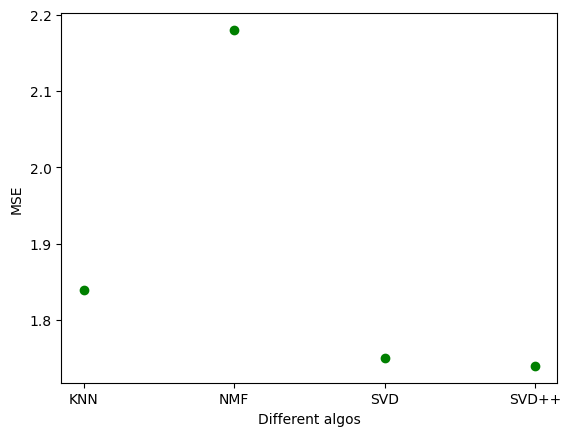

In [33]:
mses = [1.84, 2.18, 1.75, 1.74]
algos = ['KNN', "NMF", 'SVD', 'SVD++']
plt.plot(algos, mses, 'go',  )
plt.xlabel("Different algos")
plt.ylabel("MSE")
plt.show()